# Bayesian Data Analysis Project: U.S. Daily Births
### Team Members: Inon Peled, Niklas Christopher Petersen, Mads Paulsen. 
### DTU, 2018

# Introduction
In this work, we study prediction of daily births in the United States. Our dataset is a simple time series, which spans 1-Jan-2000 to 31-Dec-2014. For each day, the dataset provides the daily count of births. Our goal is to predict the count for each day in 2014, given the daily counts in 2000-2013.

The rest of the notebook is organized as following. First, we explore the dataset and patterns in it. Then, we present baseline models, followed by Stan models. In the latter, we attempt to gradually yield improved models, namely models with higher prediction accuracy. Finally, we provide a summary of our findings, and draw conclusions. We conclude with a discussion of problems and potential improvements.

# Dataset and Goal

### Imports and Commonly Used Symbols

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rcParams['figure.figsize'] = 16, 6
COMMON_SEED = 1234

# Data Description

Before fitting prediction models, let us look into the data we have.

In [4]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


We assert that no data imputation is needed.

In [5]:
def num_days_in_year(year):
    return (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1


def missing_days(df):
    return births_2000s_df_with_index.groupby('year').births.describe()\
        .assign(expected_days=lambda df: list(map(num_days_in_year, df.index)))\
        .assign(missing=lambda df: df.expected_days - df['count'])

        
assert not any(missing_days(births_2000s_df_with_index).missing)

We next show how births distribute in each year, month, and day of week. We see that whereas the data follows a somewhat steady mean and std. dev. over years and over months, there are is much more variability between days of week:
1. There are numerous outliers in each day of week.
2. There are significantly _less_ births during the weekend (Saturday-Sunday) than during the work week (Monday-Friday).
3. Weekend days have lower variance than work days.

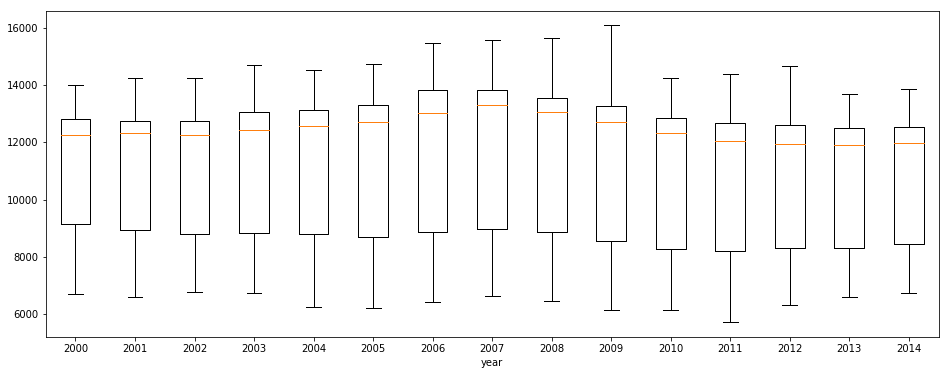

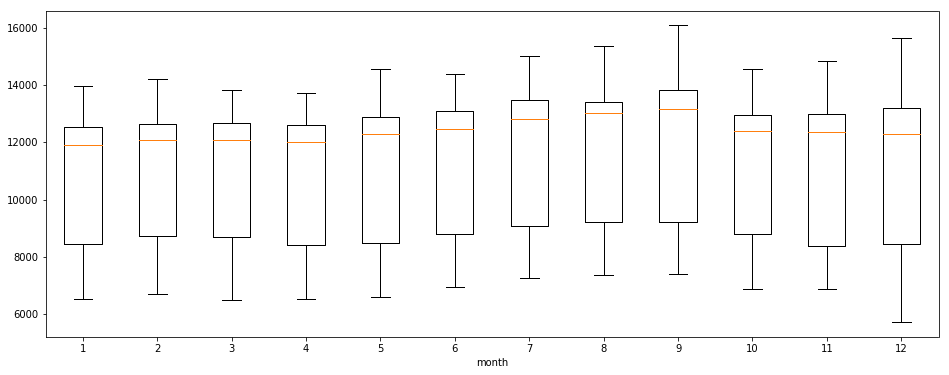

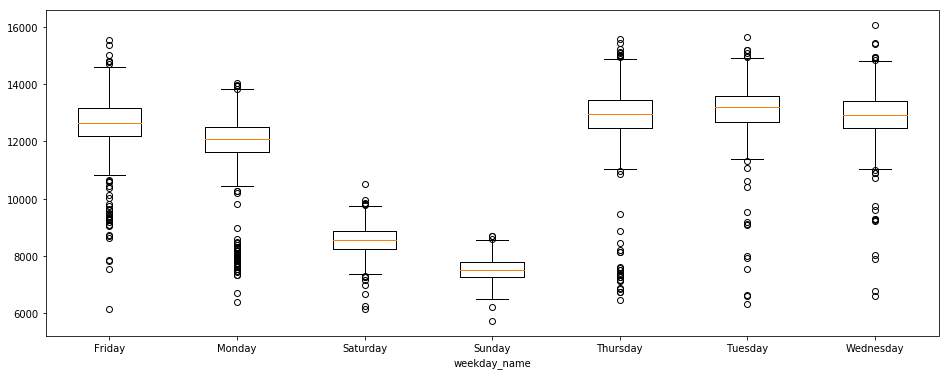

In [6]:
def boxplots(df, time_dimension):
    fig, ax = plt.subplots(1, 1)
    x = sorted(df[time_dimension].unique())
    ax.boxplot([list(df[df[time_dimension] == t].births) for t in x])
    ax.set_xticklabels(x)
    ax.set_xlabel(df[time_dimension].name)

    
for time_dimension in ('year', 'month', 'weekday_name'):
    boxplots(births_2000s_df_with_index, time_dimension)

We also take a look at the distribution of all data points, regardless of time. The distribution is markedly bimodal: one mode for weekend, the other for rest of week. In fact, the weekend distribution is bimodal too, because of differences between Saturday and Sunday.

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


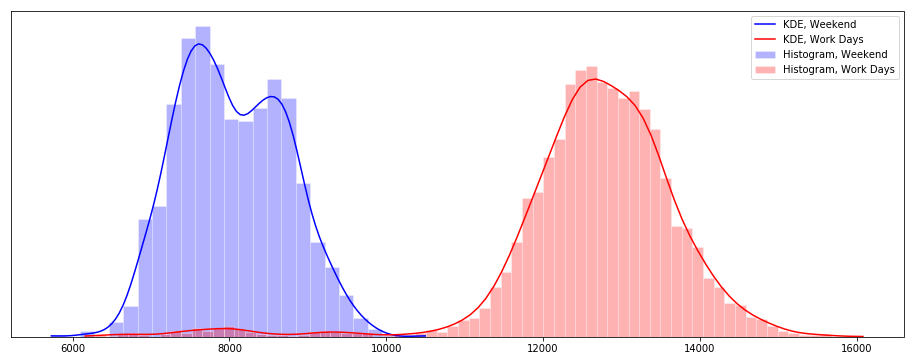

In [7]:
def density_estimation(df):
    fig, ax = plt.subplots(1, 1)
    births_weekend = df.births[df.day_of_week >= 6]
    births_work_days = df.births[df.day_of_week < 6]
    
    ax.hist(births_weekend, bins='auto', facecolor='blue', edgecolor='white', 
            normed=True, label="Histogram, Weekend", alpha=0.3)
    ax.hist(births_work_days, bins='auto', facecolor='red', edgecolor='white', 
            normed=True, label="Histogram, Work Days", alpha=0.3)

    x_kde_weekend = np.linspace(births_weekend.min(), births_weekend.max(), 100)
    ax.plot(x_kde_weekend, gaussian_kde(births_weekend)(x_kde_weekend),
            label="KDE, Weekend", color='blue')

    x_kde_work_days = np.linspace(births_work_days.min(), births_work_days.max(), 100)
    ax.plot(x_kde_work_days, gaussian_kde(births_work_days)(x_kde_work_days), label="KDE, Work Days", color='red')
    
    ax.get_yaxis().set_visible(False)
    ax.legend()
    
density_estimation(births_2000s_df_with_index)

Finally, we turn to look at Gaussian Kernel Density Estimation (KDE) for each weekday separately.

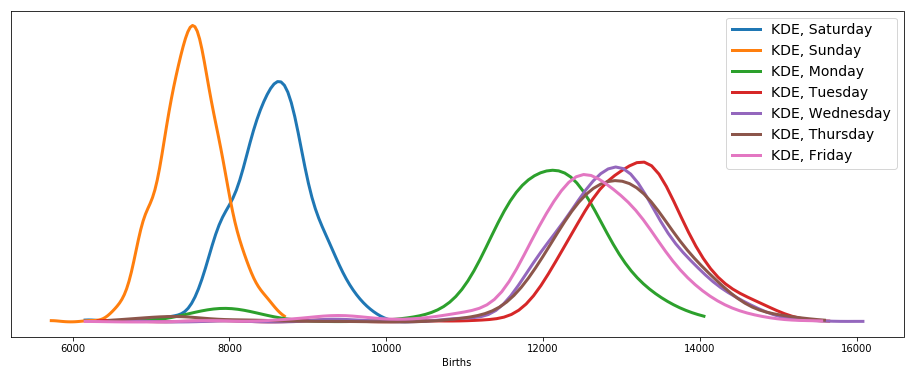

In [8]:
def density_estimation_by_weekday(df):
    fig, ax = plt.subplots(1, 1)
    for d in df.weekday_name.unique():
        daily_births = df.births[df.weekday_name == d]
        x_kde = np.linspace(daily_births.min(), daily_births.max(), 100)
        ax.plot(x_kde, gaussian_kde(daily_births)(x_kde), label="KDE, %s" % d, lw=3)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Births")
    ax.legend(fontsize=14)
    
density_estimation_by_weekday(births_2000s_df_with_index)

## Seasonality
The next few plots are meant to emphasize any obvious seasonality in the time series of births.

First, we see that each year displays are generally similar trend: steady increase in first few months, followed by a peak, a drop, and another peak at end of year.

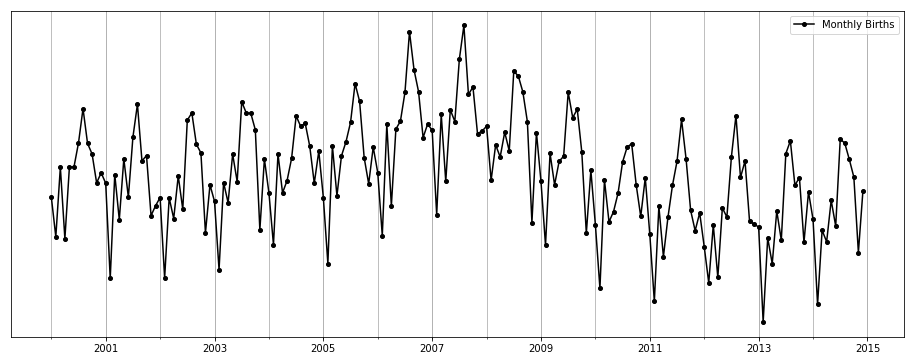

In [9]:
def plot_monthly_births(df):
    d = df.groupby(('year', 'month')).births.sum().reset_index()
    f = pd.to_datetime(d.assign(day=1).drop('births', axis=1))
    ax = d.set_index(f).drop(['year', 'month'], axis=1)\
        .births.rename("Monthly Births")\
        .plot(color="black", marker='o', markersize=4)
    ax.legend()
    ax.grid(which='both')
    ax.get_yaxis().set_visible(False)

plot_monthly_births(births_2000s_df_with_index)

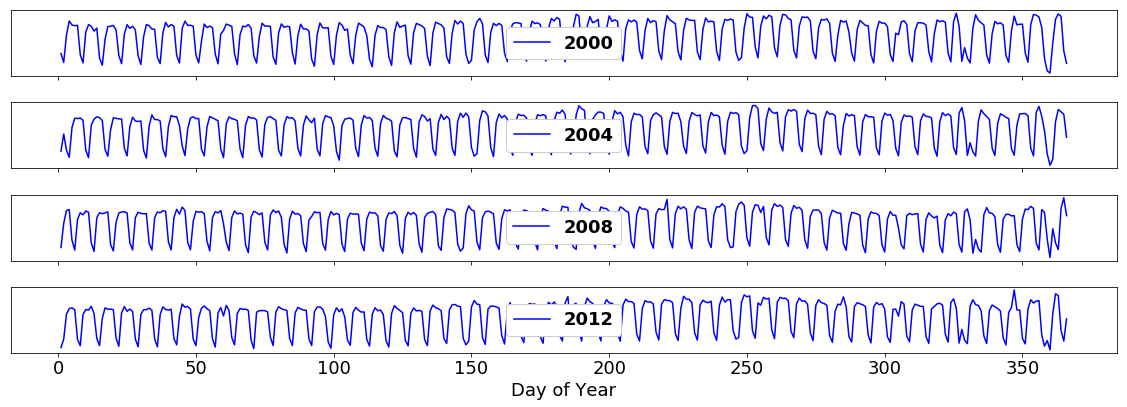

In [10]:
def compare_some_years(years):
    matplotlib.rc('font', **{'size': 18})
    fix, axes = plt.subplots(len(years), 1, sharex=True)
    for i, year in enumerate(years):
        axes[i].plot(
            births_2000s_df_with_index.set_index('day_of_year')[lambda r: r.year == year].births, 
            label=year, color='blue')
        axes[i].legend(prop={'weight':'bold'}, loc='center', framealpha=1)
        axes[i].get_yaxis().set_visible(False)
    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
        
compare_some_years(range(2000, 2015, 4))

It is known that people are biased against giving births in some specific dates: holidays, 13th of each month, and 29th Feb. on leap years. However, in this work, we will not involve any contextual information, but rather use only the births data.

## Goal: Analysis Problem
The data story we wish to study is: how well can daily births in 2014 be predicted?

Our methodology is to gradually imrpove a prediction model. As the next section shows, we will consider both models, which treat the data as samples from a daily distribution, and models which treat the data as a proper time series.

## Prediction Accuracy Measures
To compare the predictive quality of the models, we compute the following.

1. Rooted Mean Squared Error (RMSE) of prediction $\hat{y}$ against actual daily counts $y$ in 2014. That is,
$$
RMSE = \sqrt{\frac{1}{364} \sum_{i=1}^{364} \left( \hat{y}_i - y_i \right)^2}
$$
Lower RMSE implies a better model.
1. The log-likelihood of the samples from the predictive distribution, where applicable.
Higher log-likelihood implies a better model.

# Baseline Model: Historical Average (HA)
As a baseline, we use a historical average model, outside of Stan.

In [7]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2], dtype=int64),
 'x_train': array([1, 2, 3, ..., 7, 1, 2], dtype=int64),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310], dtype=int64),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525], dtype=int64)}

In [13]:
def historical_average(x_train, y_train):
    ha = np.empty(7)
    for i in range(7):
        ha[i] = y_train[x_train - 1 == i].mean()
    return ha

historical_average(x, y)

array([11897.83014049, 13122.44444444, 12910.76628352, 12845.82608696,
       12596.16240409,  8562.5734355 ,  7518.37675607])

In [11]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [15]:
def fit_ha_sliding_windows(num_windows):
    prediction_errors = []
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
#         print(data)
        y_pred = historical_average(data['x_train'], data['y_train'])[data['x_test'] - 1].round()
        prediction_errors.append(y_pred - data['y_test'])
#         print(y_pred)
#         print(data['y_test'])
    return np.concatenate(prediction_errors)

rmse(fit_ha_sliding_windows(num_windows=52))

896.5483904862673

We have thus obtained $RMSE = 896.55$ for the baseline HA. This model does not, however, yield any log-likelihood score, because it does not generate a predictive distribution.

# Stan Models and Priors

The following describes each Bayesian Inference model we try, along with justifications for choosing such a model, and a definition of the prior distributions which the model uses. For Stan models, we also provide Probabilistic Graphical Model (PGM) illustrations, which also indicate the priors we use.

Some of the models work on standardized ("detrended") data, i.e. for each data point in a train set, we remove the train set mean and then divide by the train set std. dev. The standardized data has mean zero, which we set as the location parameter of prior distributions.

For models which do not use standarized data, we derive the parameters for prior from the mean and std. dev. of year 2000. We this tacitly assume that the time series of births exhibits a reasonable level of stationarity.

## Stan Runtime Parameters
Each model runs the NUTS algorithm with a single chain and $500$ iterations, $\delta = 0.99$, and maximum tree depth $15$. We have found that these Stan parameters provide good convergence in all models.

## Convergence Measures
For each model, we check the following convergence conditions, through function "check_convergence" in the appendix:
* Are all Rhat < $1.1$?
* Have no iterations exceeded the maximum tree depth?
* Is E-BFMI low enough?
* Have at most very few iterations ended with divergence?

We also check manually for each model that $neff$, the number of effective samples, is reasonably high.

# Models for Weekdays

## Stan Model 1: Separate
In the separate model, each weekday $j$ is given an independent prior $\text{Cauchy}(\mu_j, \sigma_j)$, where $\mu_j$ equal to the sample mean and $\sigma_j$ equal to the sample standard deviation for weekday $j$. The observations are then assumed to follow a Normal distribution. This model is thus quite similar to the Separate Machines model from the windshield factory homework.

The predictive distribution is a discretized Normal, so that for $k \in \mathbb{Z}$, the value of the pmf for $k$ is $\Phi(k-0.5) - \Phi(k+0.5)$, where $\Phi$ is the cdf of the normal distribution. We perform discretization, so that we can later compare to discrete distributions in other models.

![PGM for Stan Model 1: Separate Weekdays. If this image does not display, please see it in https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_separate.png](https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_separate.png)

In [ ]:
model_separate_weekdays = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    vector[N] y_train; // Train data points.
    vector[T] y_test; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
    vector[7] prior_means;
    vector[7] prior_stds;
    real<lower=0> V_mu; // Std. dev. for priors on mu.
    real<lower=0> V_sigma; // Std. dev. for priors on sigma.
}
parameters {
    real mu[7];    // Separate means.
    real<lower=0> sigma[7]; // Separate std. devs.
}
model {
    mu ~ normal(prior_means, V_mu * prior_stds);
    sigma ~ normal(prior_stds, V_sigma * prior_stds);
    y_train ~ normal(mu[x_train], sigma[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = normal_rng(mu[x_test[t]], sigma[x_test[t]]);
        loglik += log_diff_exp(normal_lcdf(y_test[t] + 0.5 | mu[x_test[t]], sigma[x_test[t]]), normal_lcdf(y_test[t] - 0.5 | mu[x_test[t]], sigma[x_test[t]])); 
    }
}
''')

In [6]:
x = births_2000s_df_with_index.day_of_week.values
y = births_2000s_df_with_index.births.values
N = len(y)
print(x, y, N, sep='\n')

[6 7 1 ... 1 2 3]
[ 9083  8006 11363 ... 12811 13634 11990]
5479


In [10]:
fit_stan_model_on_sliding_windows(500,
    lambda data: dict(
            prior_means=weekday_priors_by_year_2000()['mean'].values,
            prior_stds=weekday_priors_by_year_2000()['std'].values,
            V_mu=4,
            V_sigma=0.5,            
            x_train=data['x_train'],
            x_test=data['x_test'],
            y_train=data['y_train'],
            y_test=data['y_test'],
            T=7,
            N=len(data['x_train'])),
    'fit_separate', model_separate_weekdays, 52)
# pickle.load(open('./fit_separate/fit0_extract.pkl', 'rb'))['mu'].shape

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.09   48.8  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.36  37.29  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.18  34.48  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    2.63  41.57  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.61  41.24  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    249    1.0
mu[5]     8539.4    1.19  18.79 8509.2 8525.8 8537.9 8552.2 8577.6    250    1.0
mu[6]     7489.3    0.96  15.15 7459.4 7478.8 7489.3 7500.6 7518.2    250    1.0
sigma[0]  1193.0    1.91  30.19 1135.0 1171.3 1193.8 1214.6 1248.8    250    1.0
sigma[1]  930.02    1.37  21.62 889.19 915.18 930.26 945.01 970.47    250    1.0
sigma

C:\Users\madsp\AppData\Local\conda\conda\envs\mbml\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.65  41.89  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.32  34.49  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    221    1.0
mu[2]      1.3e4    2.39  37.73  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    2.78  43.91  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.52  39.77  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8538.1    1.29  20.45 8494.2 8525.7 8539.3 8552.0 8578.1    250    1.0
mu[6]     7488.0    0.92  14.61 7456.6 7476.9 7489.0 7497.8 7517.2    250    1.0
sigma[0]  1179.5    2.18  29.37 1118.8 1160.7 1178.1 1199.0 1245.4    182    1.0
sigma[1]   921.0     1.6  25.34  864.9 902.59 921.76 938.62 968.57    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.58  40.72  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.67  38.51  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    208    1.0
mu[2]      1.3e4    2.46  35.49  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    208   1.01
mu[3]      1.3e4     2.8  44.26  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4     2.4   37.9  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8534.0    1.26  19.92 8486.1 8521.0 8534.7 8547.3 8572.1    250    1.0
mu[6]     7484.2    0.77  12.18 7460.0 7476.0 7483.8 7492.8 7508.3    250    1.0
sigma[0]  1176.1    2.12  33.59 1116.2 1150.6 1176.0 1198.1 1243.0    250   1.02
sigma[1]  922.39     1.8  25.08 876.17 904.95  920.4 940.02 970.58    195    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.91  45.99  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.47  38.99  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.51  39.67  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    2.62  41.47  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.35  37.09  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8531.9    1.22  19.23 8493.2 8519.5 8531.6 8548.5 8565.7    250    1.0
mu[6]     7481.1    0.98  15.47 7451.6 7469.8 7480.0 7491.4 7515.3    250    1.0
sigma[0]  1179.8    2.28  32.72 1116.2 1152.7 1182.0 1204.5 1246.9    206   1.01
sigma[1]  925.15    1.66  26.17 877.57 908.01 926.45 941.53 980.43    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.58  40.87  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    1.92  30.28  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.42  38.19  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
mu[3]      1.3e4    2.75  43.45  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    3.02  39.74  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    173    1.0
mu[5]     8527.7    1.62   19.4 8487.1 8516.4 8526.4 8541.0 8566.1    143    1.0
mu[6]     7482.0    1.77  13.85 7455.2 7471.3 7482.9 7492.1 7504.8     61   1.01
sigma[0]  1179.7     2.1  33.27 1119.1 1156.2 1178.9 1198.3 1251.1    250    1.0
sigma[1]  928.16    1.44  22.81 883.75 912.15 927.88 944.42 970.15    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.91  45.94  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4     3.1   36.7  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    140    1.0
mu[2]      1.3e4    2.76  41.35  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    225    1.0
mu[3]      1.3e4    2.79  44.19  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.53  40.07  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8524.1    1.35  17.41 8493.5 8510.8 8524.1 8536.4 8560.1    167    1.0
mu[6]     7474.9    1.03  16.26 7444.0 7463.6 7475.7 7486.9 7507.2    250   1.01
sigma[0]  1177.1    3.31  30.89 1127.6 1153.3 1174.2 1197.6 1244.4     87    1.0
sigma[1]  932.73    1.82  23.95 886.68  914.7 931.94 949.64  981.3    173    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.65  41.65  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    247    1.0
mu[1]      1.3e4    2.58  40.76  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.17  34.35  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4     3.2  50.66  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.58  40.79  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8518.4    1.12  17.75 8480.4 8507.5 8518.1 8530.1 8551.3    250    1.0
mu[6]     7472.7    0.91  13.43 7444.2 7464.2 7472.7 7481.2 7499.7    220    1.0
sigma[0]  1179.3    2.41  31.57 1116.6 1159.3 1177.0 1196.5 1245.4    171    1.0
sigma[1]  932.48    1.76  24.23 885.88 914.71 933.32 949.49 979.06    189    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.92   46.2  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.35  35.22  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    224    1.0
mu[2]      1.3e4    2.09  33.11  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.12  49.34  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.56  40.55  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8516.0    1.39  21.91 8476.6 8498.4 8515.5 8531.5 8557.2    250    1.0
mu[6]     7471.0    0.95  15.08 7439.0 7460.5 7469.6 7481.0 7506.0    250    1.0
sigma[0]  1183.6    2.15  33.99 1123.2 1158.3 1182.3 1210.2 1254.3    250    1.0
sigma[1]  932.03    1.58  25.04 886.59 914.76 931.23 945.94 986.69    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.91  46.03  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250   1.02
mu[1]      1.3e4    2.17  34.28  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.62  41.38  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    2.79  44.13  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
mu[4]      1.3e4    2.36  37.35  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8510.6    1.27  20.14 8471.5 8496.7 8509.6 8525.5 8549.7    250    1.0
mu[6]     7469.5    0.93  14.77 7439.6 7460.0 7469.7 7479.7 7496.9    250    1.0
sigma[0]  1183.5    2.24  35.35 1120.4 1155.4 1184.6 1207.0 1254.6    250    1.0
sigma[1]  932.78    1.86  25.49 888.91 915.41 931.84 947.74 987.67    187    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.58  40.81  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250   1.02
mu[1]      1.3e4    2.35  37.08  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.14  33.87  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4     2.8  44.23  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.31  36.49  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8506.1    1.28   20.3 8467.8 8492.9 8506.8 8521.9 8546.7    250    1.0
mu[6]     7466.3    0.91  14.34 7436.6 7456.4 7467.4 7474.6 7498.3    250    1.0
sigma[0]  1179.3    2.15  30.63 1117.4 1159.5 1179.3 1202.6 1235.9    203    1.0
sigma[1]  933.42     1.7  26.81 879.21 913.54 932.16 952.51 987.31    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.85  45.14  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.14   33.9  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.25  35.58  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    2.85   44.7  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    246    1.0
mu[4]      1.3e4    2.25  35.52  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8505.5    1.21  19.19 8465.8 8491.6 8505.9 8519.7 8541.9    250    1.0
mu[6]     7464.2    1.04  16.42 7431.7 7453.1 7462.7 7476.7 7494.4    250    1.0
sigma[0]  1186.3    2.02  30.85 1124.9 1165.8 1189.3 1207.2 1252.1    233    1.0
sigma[1]  936.26    2.76  23.25 895.88 918.05 937.98 951.93 983.26     71    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.94  46.48  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250   1.01
mu[1]      1.3e4    2.54  40.17  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    1.84  29.11  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    2.98  47.13  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.35  37.12  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8503.6    1.13   17.9 8472.5 8489.6 8503.8 8515.8 8537.2    250    1.0
mu[6]     7461.7    1.02  16.11 7419.9 7452.9 7461.6 7471.5 7491.3    250    1.0
sigma[0]  1181.3    2.01  31.06 1124.7 1162.7 1179.8 1199.0 1246.5    239    1.0
sigma[1]  933.59    1.56  24.63 883.34 918.64 934.96 949.55 981.51    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.66  42.07  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.46  35.87  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    212    1.0
mu[2]      1.3e4    2.18  34.54  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    2.81   44.4  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.39  37.71  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8502.8    1.24  19.53 8462.4 8490.0 8502.2 8516.8 8539.0    250    1.0
mu[6]     7459.8    0.84   13.3 7433.2 7450.7 7459.0 7469.3 7485.6    250    1.0
sigma[0]  1185.5    2.87  30.55 1127.9 1164.3 1188.1 1204.6 1249.3    113   1.01
sigma[1]  932.91    1.67  26.43 887.55 914.15 933.58 948.79 989.27    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.98  47.19  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.28   36.1  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.27  35.85  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
mu[3]      1.3e4    3.27  51.77  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.23  35.28  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8501.2    1.19  18.87 8462.4 8489.0 8501.1 8514.4 8540.6    250    1.0
mu[6]     7461.9    0.92  14.49 7433.5 7451.9 7461.9 7473.1 7485.7    250    1.0
sigma[0]  1182.0    2.98  34.09 1116.9 1156.8 1181.0 1205.4 1250.4    131   1.01
sigma[1]  930.94    1.62  25.68 881.68 914.41  931.8 945.69 984.77    250    1.0
sigma

Inference for Stan model: anon_model_82406d05cc2916e071b2909a9b6a59e5.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.21  45.73  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    203    1.0
mu[1]      1.3e4    2.98  39.61  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    177    1.0
mu[2]      1.3e4    2.47  35.66  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    208    1.0
mu[3]      1.3e4    3.56  48.49  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    186    1.0
mu[4]      1.3e4    2.16   34.2  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8498.9    1.38  18.02 8463.3 8486.5 8499.2 8511.5 8533.1    171    1.0
mu[6]     7458.9    0.83  13.07 7435.1 7449.3 7459.1 7467.9 7483.6    250    1.0
sigma[0]  1182.9    1.98  31.39 1125.0 1159.1 1181.9 1202.5 1250.5    250    1.0
sigma[1]  931.92    1.61  24.57 887.15  915.9 931.59 947.71  988.5    233    1.0
sigma

NameError: name 'rmse' is not defined

{'loglik': -56.40409544595972, 'rmse': 901.4494704644356}

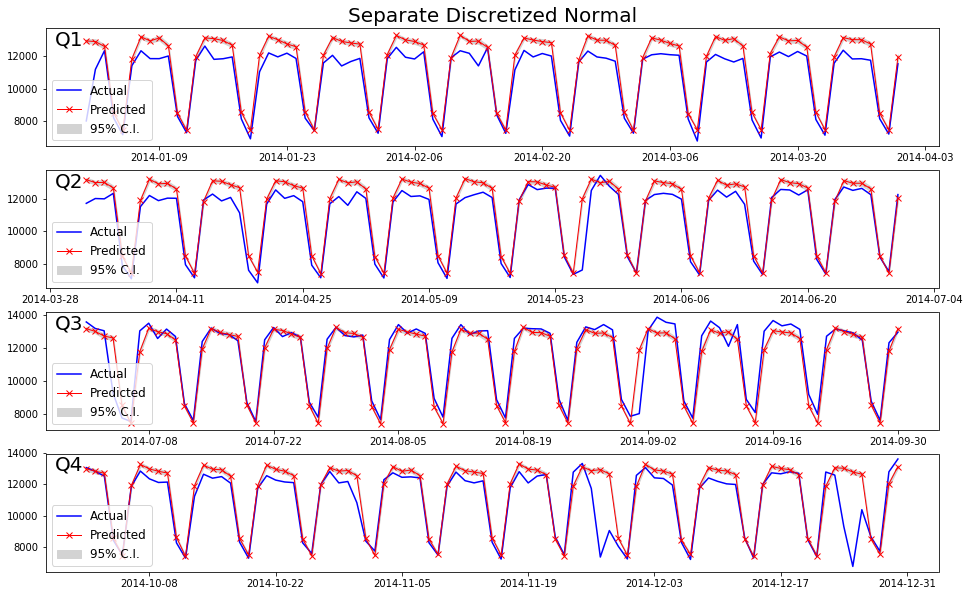

In [8]:
plot_predictions_from_pickled('fit_separate_discretized', 'Separate Discretized Normal')

Stan model 1 thus yields $loglik = -56.40$ and $RMSE = 901.45$, which is a little worse than the baseline HA.

## Stan Model 2: Two Hierarchies, Poisson
In the next model, we try to improve the prediction through two changes. First, we model weekend days separately from work days. For each case, we provide a hierarchical distribution, similarly to the hierarchical models from the windshield factory homework. Second, we model the observed values as Poisson distributed, because this is a discrete distribution of counts. The next PGM lists the priors we use here.

![PGM for Stan Model 1: Separate Weekdays. If this image does not display, please see it in https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_hierarchical_poisson.PNG](https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_hierarchical_poisson.PNG)

In [ ]:
model_hier_poisson = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    int y_train[N]; // Train data points.
    int y_test[T]; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
    real<lower=0> prior_mean_weekend;
    real<lower=0> prior_mean_workday;
    real<lower=0> prior_std_weekend;
    real<lower=0> prior_std_workday;
    real<lower=0> V_lambda; // Std. dev. for priors on lambda.
    real<lower=0> V_sigma; // Std. dev. for priors on sigma.
}
parameters {
    real<lower=0> lambda[7];
    real<lower=0> lambda_weekend;
    real<lower=0> lambda_workday;
    real<lower=0> sigma_weekend;
    real<lower=0> sigma_workday;
}
model {
    lambda_weekend ~ normal(prior_mean_weekend, V_lambda * prior_std_weekend);
    lambda_workday ~ normal(prior_mean_workday, V_lambda * prior_std_workday);
    sigma_weekend ~ normal(prior_std_weekend, V_sigma * prior_std_weekend);
    sigma_workday ~ normal(prior_std_workday, V_sigma * prior_std_workday);
    lambda[6] ~ normal(lambda_weekend, sigma_weekend);
    lambda[7] ~ normal(lambda_weekend, sigma_weekend);
    for (i in 1:5) {
        lambda[i] ~ normal(lambda_workday, sigma_workday);
    }
    y_train ~ poisson(lambda[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = poisson_rng(lambda[x_test[t]]);
        loglik += poisson_lpmf(y_test[t] | lambda[x_test[t]]);
    }
}
''')

In [14]:
def priors_for_weekend_vs_workday_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000\
        .assign(is_weekend=lambda df: df.day_of_week.isin([6, 7]))\
        .groupby('is_weekend')\
        .agg(['mean', 'std'])\
        .births

priors_for_weekend_vs_workday_by_year_2000()
# priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0]

,mean,std
is_weekend,,
False,12481.507692,909.221295
True,8532.132075,614.062616


In [ ]:
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=7))
fit = model_hier_poisson.sampling(seed=COMMON_SEED, data=dict(
    V_lambda=4,
    V_sigma=0.2,
    prior_mean_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0],
    prior_mean_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['mean'].values[0],
    prior_std_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['std'].values[0],
    prior_std_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['std'].values[0],
    x_train=data['x_train'],
    x_test=data['x_test'],
    y_train=data['y_train'],
    y_test=data['y_test'],
    T=7,
    N=len(data['x_train'])), iter=500)
check_convergence(fit, also_print=True)

In [ ]:
fit_stan_model_on_sliding_windows(
    1000,
    lambda data: dict(
        V_lambda=4,
        V_sigma=0.2,
        prior_mean_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0],
        prior_mean_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['mean'].values[0],
        prior_std_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['std'].values[0],
        prior_std_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['std'].values[0],
        x_train=data['x_train'],
        x_test=data['x_test'],
        y_train=data['y_train'],
        y_test=data['y_test'],
        T=7,
        N=len(data['x_train'])),
    'fit_hier_poisson', model_hier_poisson, 1)

Ref. appendix 2 for the long fit details.

{'loglik': -287.4199782700962, 'rmse': 897.1197308831815}

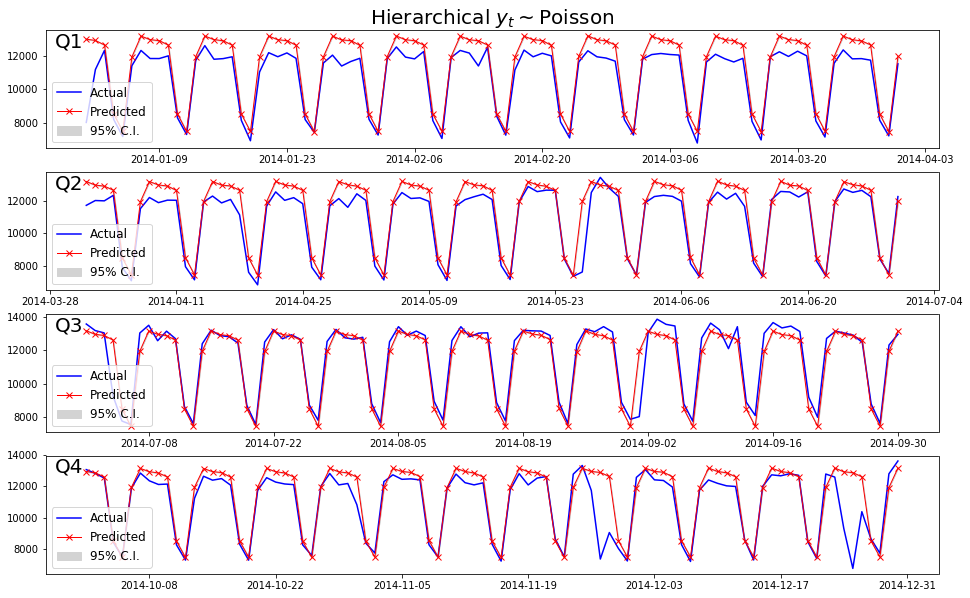

In [29]:
plot_predictions_from_pickled('fit_hier_poisson', 'Hierarchical $y_t \sim$Poisson')

We obtain poor predictive accuracy for Stan model 2, because the Poisson distribution does not fit well the high over-dispersion in this time series.

# Stan Models for Time Series

# Appendix: Utility Functions
The following functions have been used above repeatedly. We have moved these to the end of the notebook for ease of reading.

In [3]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [4]:
def loglik_from_pickled(dirname):
    return np.concatenate(list(pickle.load(gzip.open(f, 'rb'))['loglik'][:250]
        for f in glob.glob(os.path.join(dirname, 'fit*_extract.pkl.gz')))).mean()

In [5]:
def plot_quarterly(model_name, mean_predictions, ci_95_half_widths, y_test_2014):
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
                
    def rmse(prediction_errors):
        return (prediction_errors ** 2).mean() ** 0.5
    
    def filter_date_range(series, from_date_inclusive, to_date_inclusive):
            return series\
                [lambda df: df.index >= from_date_inclusive]\
                [lambda df: df.index < to_date_non_inclusive]
    
    plt.tight_layout()
    for i, (quarter, from_date_inclusive, to_date_non_inclusive) in enumerate([
        ('Q1', datetime(2014, 1, 1), datetime(2014, 4, 1)),
        ('Q2', datetime(2014, 4, 1), datetime(2014, 7, 1)),
        ('Q3', datetime(2014, 7, 1), datetime(2014, 10, 1)),
        ('Q4', datetime(2014, 10, 1), datetime(2014, 12, 31))
    ]):    
        
        plt.subplot(411 + i)
        plt.plot(filter_date_range(y_test_2014, from_date_inclusive, to_date_non_inclusive), "b-", label='Actual', lw=1.5)
        plt.plot(filter_date_range(mean_predictions, from_date_inclusive, to_date_non_inclusive), "r-x", label='Predicted', lw=1)
        plt.fill_between(filter_date_range(y_test_2014, from_date_inclusive, to_date_non_inclusive).index, 
                         filter_date_range(mean_predictions + ci_95_half_widths, from_date_inclusive, to_date_non_inclusive),
                         filter_date_range(mean_predictions - ci_95_half_widths, from_date_inclusive, to_date_non_inclusive),
                         color='lightgrey', label='95% C.I.')
        plt.legend(loc='lower left', fontsize=12)
        plt.text(0.01, 0.9, quarter, fontsize=20,
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        if i == 0:
            plt.title(model_name, fontsize=20)
    
    return rmse(filter_date_range(mean_predictions, datetime(2014, 1, 1), datetime(2014, 12, 31)) -
                filter_date_range(y_test_2014, datetime(2014, 1, 1), datetime(2014, 12, 31)))

In [ ]:
def plot_predictions_from_pickled(results_directory, model_name):
    rcParams['figure.figsize'] = 16, 10
    prediction_samples = np.concatenate(list(pickle.load(gzip.open(f, 'rb'))['y_pred'][:250, -7:]
        for f in glob.glob(os.path.join(results_directory, 'fit*_extract.pkl.gz'))), axis=1)
    sample_size = prediction_samples.shape[0]
    
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
    
    mean_predictions = add_date_index(prediction_samples.mean(axis=0))
    std_predictions = add_date_index(prediction_samples.std(axis=0))
    ci_95_hw = 1.96 * std_predictions / (sample_size ** 0.5)
    
    births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
    y_test_2014 = births_2000s_df\
        .rename(columns={'date_of_month': 'day'})\
        .set_index(pd.to_datetime(
            births_2000s_df.rename(columns={'date_of_month': 'day'})
            [['year', 'month', 'day']]))\
        .births[lambda df: df.index >= datetime(2014, 1, 1)]
    
    return {
        'rmse': plot_quarterly(model_name, mean_predictions, ci_95_hw, y_test_2014),
        'loglik': loglik_from_pickled(results_directory)
    }

In [7]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2], dtype=int64),
 'x_train': array([1, 2, 3, ..., 7, 1, 2], dtype=int64),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310], dtype=int64),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525], dtype=int64)}

In [5]:
def weekday_priors_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000.groupby('day_of_week').agg(['mean', 'std']).births

weekday_priors_by_year_2000()

,mean,std
day_of_week,,
1,11514.461538,1036.715902
2,12870.846154,790.289954
3,12762.269231,422.905919
4,12735.461538,813.567006
5,12524.500000,634.105530
6,9049.830189,344.643056
7,8014.433962,310.302366


In [ ]:
def check_convergence(fit, also_print=False):
    report = print if also_print else lambda x: None
    
    def all_rhat_small_enough(fit):
        return all(dict(fit.summary())['summary'][:, -1] < 1.1)
    
    def max_treedepth_exceeded(fit, max_depth = 10):
        """Check transitions that ended prematurely due to maximum tree depth limit"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        depths = [x for y in sampler_params for x in y['treedepth__']]
        n = sum(1 for x in depths if x == max_depth)
        if n > 0:
            report('Run again with max_depth set to a larger value to avoid saturation')        
        N = len(depths)
        report(('{} of {} iterations saturated the maximum tree depth of {}'
               + ' ({}%)').format(n, N, max_depth, 100 * n / N))
        return float(n) / N
    
    def e_bfmi_all_low_enough(fit):
        """
        Checks the energy Bayesian fraction of missing information (E-BFMI).
        E-BFMI below 0.2 indicates you may need to reparameterize your model
        """
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        for chain_num, s in enumerate(sampler_params):
            energies = s['energy__']
            numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
            denom = np.var(energies)
            if numer / denom < 0.2:
                report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
                report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
                return False
        return True

    def fraction_of_transitions_which_ended_with_divergence(fit):
        """Check transitions that ended with a divergence"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        divergent = [x for y in sampler_params for x in y['divergent__']]
        n = sum(divergent)
        N = len(divergent)
        report('{} of {} iterations ended with a divergence ({}%)'
              .format(n, N, 100 * n / N))
        if n > 0:
            report('Try running with larger adapt_delta to remove the divergences')
        return n / N
    
    assert all_rhat_small_enough(fit)
    assert max_treedepth_exceeded(fit) < 0.02
    assert e_bfmi_all_low_enough(fit)
    assert fraction_of_transitions_which_ended_with_divergence(fit) == 0
    report("##### All convergence checks passed successfully. #####")